# Brain Tumor Detection
---
Group members:


*   Francesca Sotgia - 513067
*   Cristian Abid - 515378
*   Gabriele Dell'Atti - 5128758
*   Bahenda Yvon Dylan Ntegano - 515657

## Imports

We import the libraries that we will use throughout. \
The main ones are:
- `sklearn` for the evaluation and calibration metrics.
- `tensorflow` for the models.
- `lime` for the explainability.
- `mlflow` for the management and monitoring of the model.

In [ ]:
! pip install mlflow

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#---------------------------------------
from sklearn.metrics import (
    classification_report, confusion_matrix, matthews_corrcoef,
    brier_score_loss
    )
from sklearn.metrics import roc_curve, auc as sklearn_auc
from sklearn.calibration import calibration_curve
#---------------------------------------
import tensorflow as tf
from tensorflow.keras import layers, Model
#---------------------------------------
from lime import lime_image
from skimage.segmentation import mark_boundaries
import pickle
#---------------------------------------
import mlflow
from mlflow import *
from mlflow.models import infer_signature
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

## Data Loading

We download the dataset from kaggle.

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\ENVY\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1


## Preprocessing

We load the datasets which are already split into "Training" and "Testing" sets. We further split the "Training" set into "Training" and "Validation" subsets --70% for train and 30% for validation--, and resize them to a sixe of 224x224 for the model.

In [3]:
# Path to training and test folders
train_dir = os.path.join(path, "Training")
test_dir = os.path.join(path, "Testing")

# Load the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=64,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.3,
    subset="validation",
    seed=123,  # Ensure consistency
    image_size=(224, 224),
    batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=64
)

# Print dataset sizes
print(f"Training batches: {len(train_ds)}")
print(f"Validation batches: {len(val_ds)}")
print(f"Test batches: {len(test_ds)}")

Found 5712 files belonging to 4 classes.
Using 3999 files for training.
Found 5712 files belonging to 4 classes.
Using 1713 files for validation.
Found 1311 files belonging to 4 classes.
Training batches: 63
Validation batches: 27
Test batches: 21


We define a function to convert the images to float32 and normalize to [0, 1] for better compatibility with the model. We then apply this function to the dataset.

In [4]:
# Normalization function
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply the normalization function to each dataset
train_dataset = train_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset   = val_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset  = test_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)

## Data Visualization

We visualize the class names and their corresponding indices, as well as the images with their labels, to ensure the data is as we expect it to be.

In [5]:
for i, label in enumerate(train_ds.class_names):
    print(f"Label {i}: {label}")

Label 0: glioma
Label 1: meningioma
Label 2: notumor
Label 3: pituitary


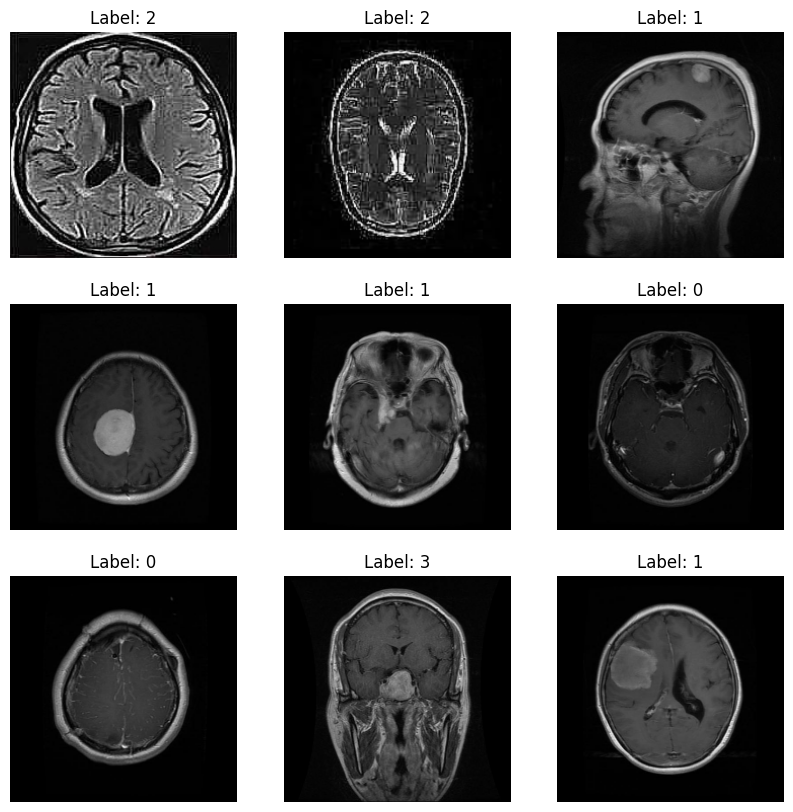

In [6]:
plt.figure(figsize=(10, 10))

for image_batch, label_batch in train_dataset.take(1):  # Taking one batch for demonstration
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy())
        plt.title(f"Label: {label_batch[i].numpy()}")
        plt.axis("off")

plt.show()


## Model

We define our model architecture which is made up of:
- Input layer.
- Base model: a pretrained CNN architecture "`MobileNetV2`"
- Pooling layer.
- Output layer.

In [5]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False  # Freeze the base model

# Define Functional model
inputs = tf.keras.Input(shape=(224, 224, 3))        # Define input layer
x = base_model(inputs, training=False)              # Pass inputs to base model
x = layers.GlobalAveragePooling2D()(x)              # Global Average Pooling
outputs = layers.Dense(4, activation='softmax')(x)  # Output layer (4 classes)

# Create Functional model
tl_model = Model(inputs, outputs)

# Compile the model
tl_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
              metrics=['accuracy'])

# Summary of the model
tl_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Model Training

We train our previously defined model on the `train_dataset` and `val_dataset`, and then evaluate it on the `test_dataset.`

In [7]:
mlflow.set_tracking_uri("http://127.0.0.1:500/")
mlflow.set_experiment("brain_tumor_classification")

<Experiment: artifact_location=('file:c:/Users/ENVY/OneDrive - Università di Pavia/Desktop/Uni/Year 3/Second '
 'Semester/Lab - Medical Devices & Systems/Project/mlruns/1'), creation_time=1745914731205, experiment_id='1', last_update_time=1745914731205, lifecycle_stage='active', name='brain_tumor_classification', tags={}>

In [ ]:
mlflow.autolog(log_models=False)
# Start an MLflow run
mlflow.start_run()

# Log the model
mlflow.set_tag("model_type", "MobileNetV2")
    
# Train the model
history = tl_model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

# Testing
test_loss, test_accuracy = tl_model.evaluate(test_dataset, verbose=1)
mlflow.log_metric("test_accuracy", test_accuracy)
mlflow.log_metric("test_loss", test_loss)

2025/04/29 17:03:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/04/29 17:03:21 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9769 - loss: 0.0880 - val_accuracy: 0.9358 - val_loss: 0.1872
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 941ms/step - accuracy: 0.9766 - loss: 0.0865 - val_accuracy: 0.9329 - val_loss: 0.1832
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9800 - loss: 0.0804 - val_accuracy: 0.9323 - val_loss: 0.1809
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 954ms/step - accuracy: 0.9804 - loss: 0.0777 - val_accuracy: 0.9311 - val_loss: 0.1899
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9804 - loss: 0.0768 - val_accuracy: 0.9335 - val_loss: 0.1786
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 684ms/step - accuracy: 0.9301 - loss: 0.1788


In [137]:
# Take one batch of images and labels
for sample_images, sample_labels in test_dataset.take(1):
    sample_input = sample_images.numpy()
    sample_output = tl_model.predict(sample_images)
    break
signature = infer_signature(sample_input, sample_output)
signature

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step


inputs: 
  [Tensor('float32', (-1, 224, 224, 3))]
outputs: 
  [Tensor('float32', (-1, 4))]
params: 
  None

In [ ]:
# Save the model
mlflow.tensorflow.log_model(
    model=tl_model, 
    artifact_path="model",
    signature=signature,
    registered_model_name="Brain-Tumor-Classifier",
    metadata={"model_type": "MobileNetV2", "input_shape": str(sample_input.shape), "output_shape": str(sample_output.shape)}
)

Registered model 'Brain-Tumor-Classifier' already exists. Creating a new version of this model...
2025/04/29 17:09:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Brain-Tumor-Classifier, version 5
Created version '5' of model 'Brain-Tumor-Classifier'.


In [ ]:
# Save the model
tl_model.save("brain_tumor_classifier.h5")

We visualize the accuracy curve for the training and validation subsets.

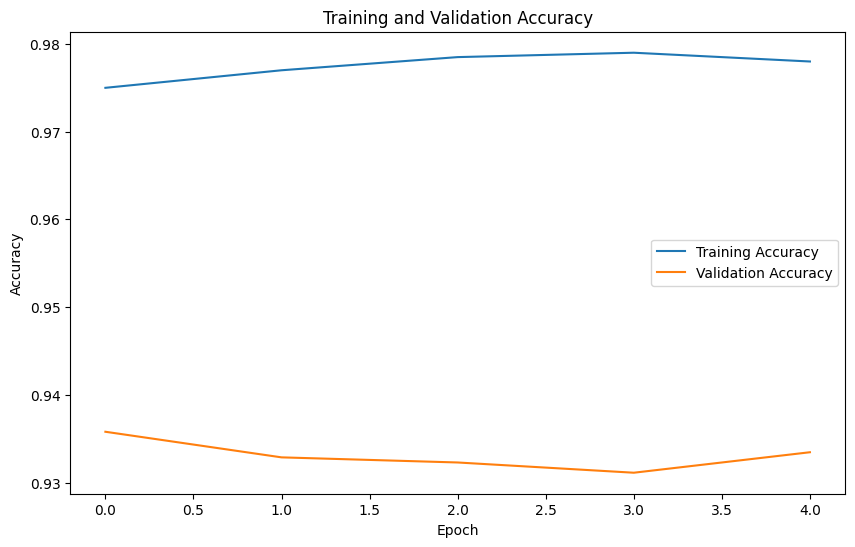

In [141]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')       # Plot the training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') # Plot the validation accuracy
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig("accuracy_plot.png")
mlflow.log_artifact("accuracy_plot.png")
plt.show()


## Model Evaluation

We use our trained model to make predictions on the test set and use these results to generate some evaluation metrics, which are:
- Classification report: precision, recall, f1_score, and accuracy.
- Confusion matrix.
- Sensitivity and Specificity.
- Matthews Correlation Coefficient.
- ROC curve.

In [ ]:
# Load the trained model
# model = tf.keras.models.load_model("brain_tumor_classifier.h5") 
model_uri = "runs:/7756e00800464bf6a92382501d68e94b/model"
model = mlflow.tensorflow.load_model(model_uri)

In [143]:
# Collect all true labels and predictions
true_labels = []
predicted_probs = []

for images, labels in test_dataset:
    predictions = model.predict(images)  # Get model predictions
    predicted_probs.extend(predictions)  # Get predicted classes
    true_labels.extend(labels.numpy())  # Store true labels

# Ensure correct label mapping
class_names = test_ds.class_names

# Convert to numpy arrays
true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

# Get the predicted classes
predicted_labels = np.argmax(predicted_probs, axis=1)

# Generate and display the classification report
print(classification_report(true_labels, predicted_labels, target_names=class_names))

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 497ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 487ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 477ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 479ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 481ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 488ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 482ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
              precision    recall  f1-score   support

      glioma       0.95      0.83      0.89       300
  meningioma       0.79      0.88      0.83       306
     notumor       0.

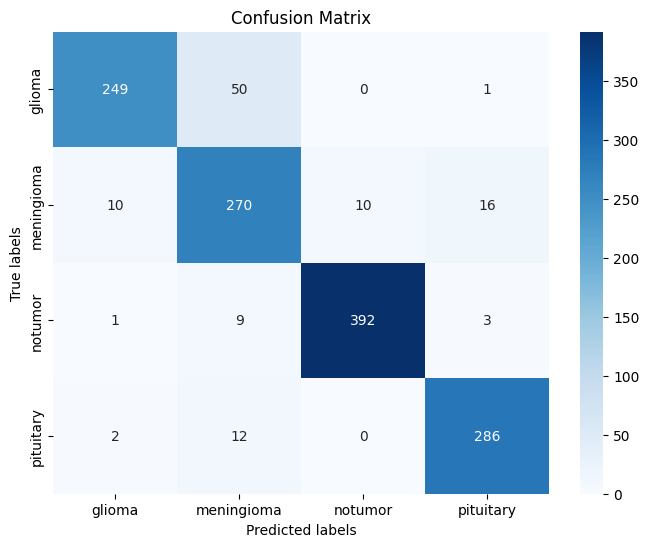

In [144]:
# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_ds.class_names, yticklabels=train_ds.class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png")
mlflow.log_artifact("confusion_matrix.png")
plt.show()

In [145]:
num_classes = len(class_names)

def sensitivity_specificity(cm):
    sens = []
    spec = []
    for i in range(num_classes):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = np.sum(cm) - (TP + FN + FP)

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

        sens.append(sensitivity)
        spec.append(specificity)

    return sens, spec

sens, spec = sensitivity_specificity(cm)

In [146]:
# Create a DataFrame for sensitivity and specificity
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Sensitivity': sens,
    'Specificity': spec
})

# Display the table
print(metrics_df)
avg_sensitivity = np.mean(sens)
avg_specificity = np.mean(spec)
mlflow.log_metric("avg_sensitivity", avg_sensitivity)
mlflow.log_metric("avg_specificity", avg_specificity)

        Class  Sensitivity  Specificity
0      glioma     0.830000     0.987141
1  meningioma     0.882353     0.929353
2     notumor     0.967901     0.988962
3   pituitary     0.953333     0.980218


In [147]:
mcc = matthews_corrcoef(true_labels, predicted_labels)
print(f"Matthews Correlation Coefficient: {mcc}")
mlflow.log_metric("mcc", mcc)

Matthews Correlation Coefficient: 0.8842822841652255


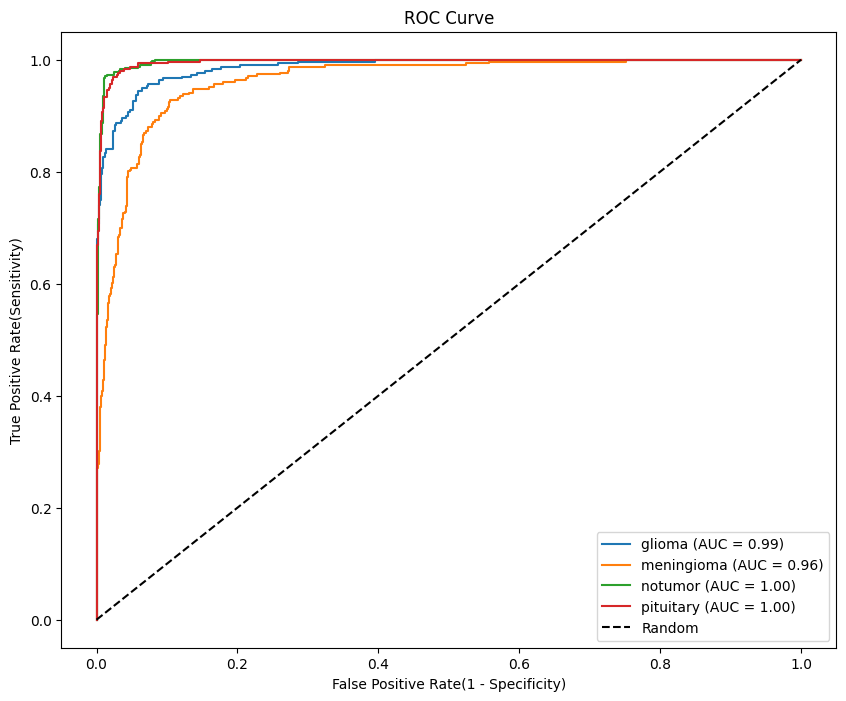

In [148]:
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve((true_labels == i).astype(int), predicted_probs[:, i])
    roc_auc = sklearn_auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate(1 - Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.title('ROC Curve')
plt.legend()
plt.savefig("roc_curve.png")
mlflow.log_artifact("roc_curve.png")
plt.show()

We also generate some calibration metrics:
- Brier score.
- Calibration curve / Reliability Diagram.

In [149]:
brier_scores = []
for i in range(num_classes):
    brier = brier_score_loss((np.array(true_labels) == i).astype(float), (np.array(predicted_labels) == i).astype(float))
    brier_scores.append(brier)
    print(f"Brier Score for class {class_names[i]}: {brier}")

# Calculate the average Brier score
avg_brier_score = np.mean(brier_scores)
print(f"Average Brier Score: {avg_brier_score}")
mlflow.log_metric("avg_brier_score", avg_brier_score)

Brier Score for class glioma: 0.04881769641495042
Brier Score for class meningioma: 0.08161708619374523
Brier Score for class notumor: 0.017543859649122806
Brier Score for class pituitary: 0.02593440122044241
Average Brier Score: 0.043478260869565216


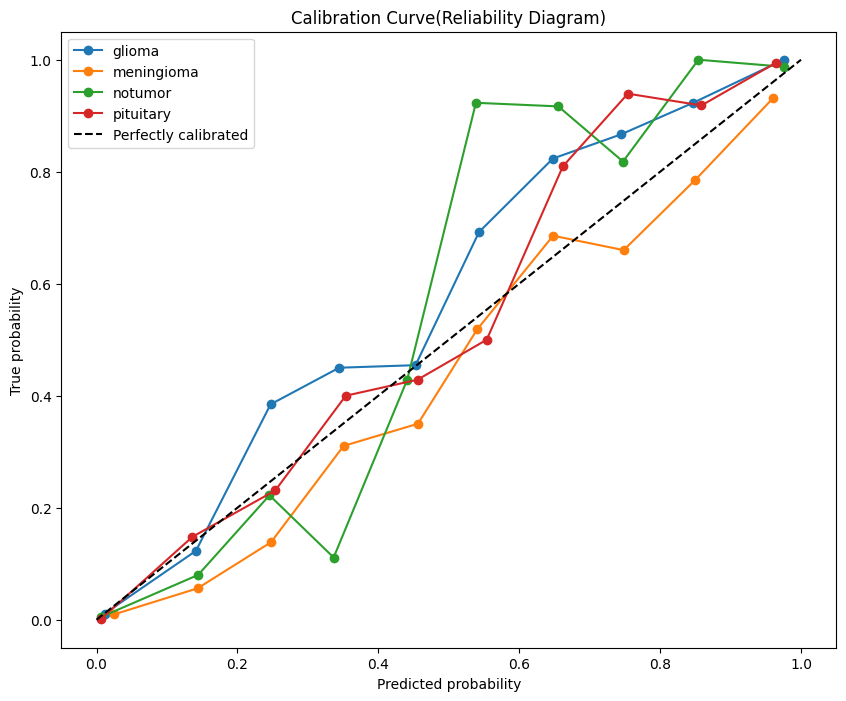

In [150]:
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    prob_true, prob_pred = calibration_curve((true_labels == i).astype(int), predicted_probs[:, i], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=f"{class_names[i]}")

plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Curve(Reliability Diagram)')
plt.legend()
plt.savefig("calibration_curve.png")
mlflow.log_artifact("calibration_curve.png")
plt.show()

## Model Explainability

We used lime, more specifically `LimeImageExplainer`

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

<function matplotlib.pyplot.show(close=None, block=None)>

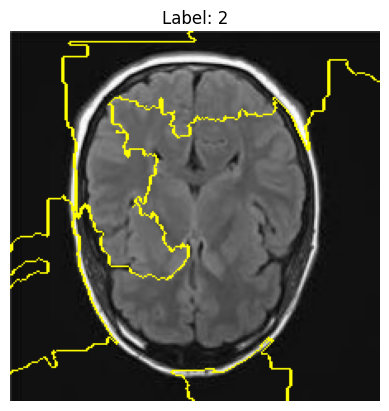

In [ ]:
def predict_fn(images):
    predictions = model.predict(images)
    return np.array(predictions)

n = 0
image_batch, label_batch = next(iter(test_dataset))
image = image_batch[n].numpy()
label = label_batch[n].numpy()

explainer = lime_image.LimeImageExplainer()
# Get the explanation for the first image in the test set
explanation = explainer.explain_instance(
    image,
    predict_fn,
    top_labels=3,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    label,
    positive_only=True,
    num_features=10,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp, mask))
plt.title(f"Label: {label}")
plt.axis('off')
plt.show

In [152]:
mlflow.end_run()  # End the MLflow run

🏃 View run sincere-doe-275 at: http://127.0.0.1:500/#/experiments/1/runs/7756e00800464bf6a92382501d68e94b
🧪 View experiment at: http://127.0.0.1:500/#/experiments/1


Code to run the mlflow server:
- mlflow server --backend-store-uri sqlite:///mlruns.db --default-artifact-root ./mlruns --host 127.0.0.1 --port 500